BSM Call Price: 10.45
BSM Put Price: 5.57
Binomial Tree Call Price: 10.43
Binomial Tree Put Price: 5.55
Monte Carlo Call Price: 10.08
Monte Carlo Put Price: 5.62
Delta (Call): 0.6368
Gamma (Call): 0.0188
Futures Price: 107.25
Bond Price: 1081.11


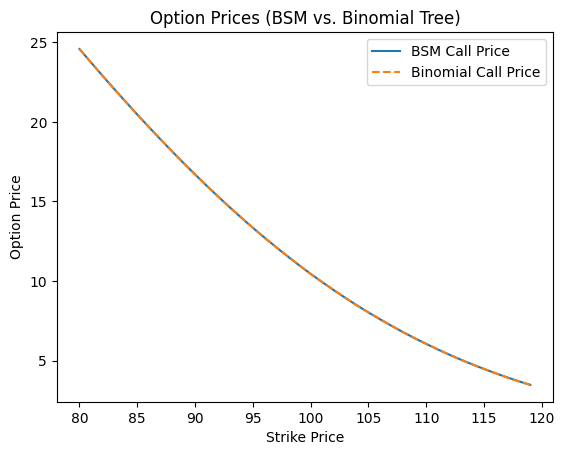

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Black-Scholes-Merton (BSM) Model
def bsm_option_price(S, K, T, r, sigma, option_type="call"):
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == "call":
        price = S * stats.norm.cdf(d1) - K * np.exp(-r * T) * stats.norm.cdf(d2)
    elif option_type == "put":
        price = K * np.exp(-r * T) * stats.norm.cdf(-d2) - S * stats.norm.cdf(-d1)
    return price

# Binomial Tree Model
def binomial_tree_option_price(S, K, T, r, sigma, steps=100, option_type="call"):
    dt = T / steps
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)
    
    option_prices = np.zeros(steps + 1)
    
    for i in range(steps + 1):
        S_T = S * (u ** i) * (d ** (steps - i))
        if option_type == "call":
            option_prices[i] = max(S_T - K, 0)
        elif option_type == "put":
            option_prices[i] = max(K - S_T, 0)
    
    for j in range(steps - 1, -1, -1):
        for i in range(j + 1):
            option_prices[i] = np.exp(-r * dt) * (p * option_prices[i + 1] + (1 - p) * option_prices[i])
    
    return option_prices[0]

# Monte Carlo Simulation
def monte_carlo_option_price(S, K, T, r, sigma, simulations=10000, option_type="call"):
    np.random.seed(0)
    ST = S * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * np.random.standard_normal(simulations))
    if option_type == "call":
        payoff = np.maximum(ST - K, 0)
    elif option_type == "put":
        payoff = np.maximum(K - ST, 0)
    option_price = np.exp(-r * T) * np.mean(payoff)
    return option_price

# First and Second-order Greeks using Taylor Approximation
def delta(S, K, T, r, sigma, option_type="call", epsilon=0.01):
    price_up = bsm_option_price(S + epsilon, K, T, r, sigma, option_type)
    price_down = bsm_option_price(S - epsilon, K, T, r, sigma, option_type)
    return (price_up - price_down) / (2 * epsilon)

def gamma(S, K, T, r, sigma, option_type="call", epsilon=0.01):
    price_up = bsm_option_price(S + epsilon, K, T, r, sigma, option_type)
    price_down = bsm_option_price(S - epsilon, K, T, r, sigma, option_type)
    price = bsm_option_price(S, K, T, r, sigma, option_type)
    return (price_up - 2 * price + price_down) / (epsilon ** 2)

# Cost-of-Carry Model for Forwards and Futures
def futures_price(S, r, T, carry_cost=0):
    return S * np.exp((r + carry_cost) * T)

# Simulate Pricing of US Treasury Bonds (T-bonds)
def bond_price(face_value, coupon_rate, periods, ytm):
    coupon = face_value * coupon_rate
    price = 0
    for t in range(1, periods + 1):
        price += coupon / (1 + ytm) ** t
    price += face_value / (1 + ytm) ** periods
    return price

if __name__ == "__main__":
    # Given Data
    S = 100          # Spot price of underlying
    K = 100          # Strike price
    T = 1            # Time to maturity (1 year)
    r = 0.05         # Risk-free rate
    sigma = 0.2      # Volatility of underlying asset
    face_value = 1000 # Face value of bond
    coupon_rate = 0.05 # 5% annual coupon rate
    periods = 10      # 10 years to maturity
    ytm = 0.04        # Yield to maturity of 4%
    
    # BSM Model Pricing
    bsm_call_price = bsm_option_price(S, K, T, r, sigma, option_type="call")
    bsm_put_price = bsm_option_price(S, K, T, r, sigma, option_type="put")
    
    print(f"BSM Call Price: {bsm_call_price:.2f}")
    print(f"BSM Put Price: {bsm_put_price:.2f}")
    
    # Binomial Tree Pricing
    binomial_call_price = binomial_tree_option_price(S, K, T, r, sigma, steps=100, option_type="call")
    binomial_put_price = binomial_tree_option_price(S, K, T, r, sigma, steps=100, option_type="put")
    
    print(f"Binomial Tree Call Price: {binomial_call_price:.2f}")
    print(f"Binomial Tree Put Price: {binomial_put_price:.2f}")
    
    # Monte Carlo Simulation Pricing
    monte_carlo_call_price = monte_carlo_option_price(S, K, T, r, sigma, simulations=10000, option_type="call")
    monte_carlo_put_price = monte_carlo_option_price(S, K, T, r, sigma, simulations=10000, option_type="put")
    
    print(f"Monte Carlo Call Price: {monte_carlo_call_price:.2f}")
    print(f"Monte Carlo Put Price: {monte_carlo_put_price:.2f}")
    
    # First and Second Order Greeks
    delta_call = delta(S, K, T, r, sigma, option_type="call")
    gamma_call = gamma(S, K, T, r, sigma, option_type="call")
    
    print(f"Delta (Call): {delta_call:.4f}")
    print(f"Gamma (Call): {gamma_call:.4f}")
    
    # Pricing Forwards and Futures using Cost-of-Carry Model
    futures_price_val = futures_price(S, r, T, carry_cost=0.02)
    print(f"Futures Price: {futures_price_val:.2f}")
    
    # Bond Pricing (US Treasury Bond)
    bond_price_val = bond_price(face_value, coupon_rate, periods, ytm)
    print(f"Bond Price: {bond_price_val:.2f}")
    
    # Plotting Option Payoffs for BSM and Binomial Models
    strike_prices = np.arange(80, 120, 1)
    bsm_call_prices = [bsm_option_price(S, k, T, r, sigma, option_type="call") for k in strike_prices]
    binomial_call_prices = [binomial_tree_option_price(S, k, T, r, sigma, steps=100, option_type="call") for k in strike_prices]
    
    plt.plot(strike_prices, bsm_call_prices, label='BSM Call Price')
    plt.plot(strike_prices, binomial_call_prices, label='Binomial Call Price', linestyle='--')
    plt.xlabel("Strike Price")
    plt.ylabel("Option Price")
    plt.legend()
    plt.title("Option Prices (BSM vs. Binomial Tree)")
    plt.show()
